In [2]:
from sympy import symbols
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd

from PIL import Image

In [3]:
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

## Importing the dataset

Firstly, the data should be imported into the pandas dataframes for easy manipulation. 

In [4]:
batch_size = 16
data_dir = "/Users/anna-alexandradanchenko/Documents/University/IdentMathFunc/Math-Functions-Identification/data"
img_height = 224
img_width = 224


# Some images are png with transparency. We need to set the white background for them so they won't appear black for the model. 
for subdir, dirs, files in os.walk(data_dir): # Iterate throught all the levels of the directories 
    for file in files:
        if file.endswith('.png'):
            img = Image.open(os.path.join(subdir, file))
            if img.mode == "RGBA":                     # Choose only images with transparency
                white_background_image = Image.new("RGBA", img.size, "WHITE") # Create a white rgba background
                white_background_image.paste(img, (0, 0), img) # Paste original png image on top of the white background
                final_img = white_background_image.convert("RGB")

                final_img.save((os.path.join(subdir, file))) # Save the image with the same filename


# for filename in os.listdir(data_dir):
#     img = Image.open(data_dir + "/" + filename)

In [5]:
# Converts images to floating-point tensors automatically

df_train_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="training",

    labels='inferred',
    label_mode="categorical",
        
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=True
)

df_valid_ = image_dataset_from_directory(
    data_dir,

    validation_split=0.2,
    subset="validation",

    labels='inferred',
    label_mode="categorical",
    
    color_mode='rgb',

    image_size=[img_height, img_width],
    batch_size=batch_size,

    seed = 123,     
    interpolation='nearest',
    shuffle=False
)


Found 203 files belonging to 2 classes.


Using 163 files for training.
Found 203 files belonging to 2 classes.
Using 40 files for validation.


In [6]:
class_names = df_train_.class_names
print(class_names)

['linear', 'quadratic']


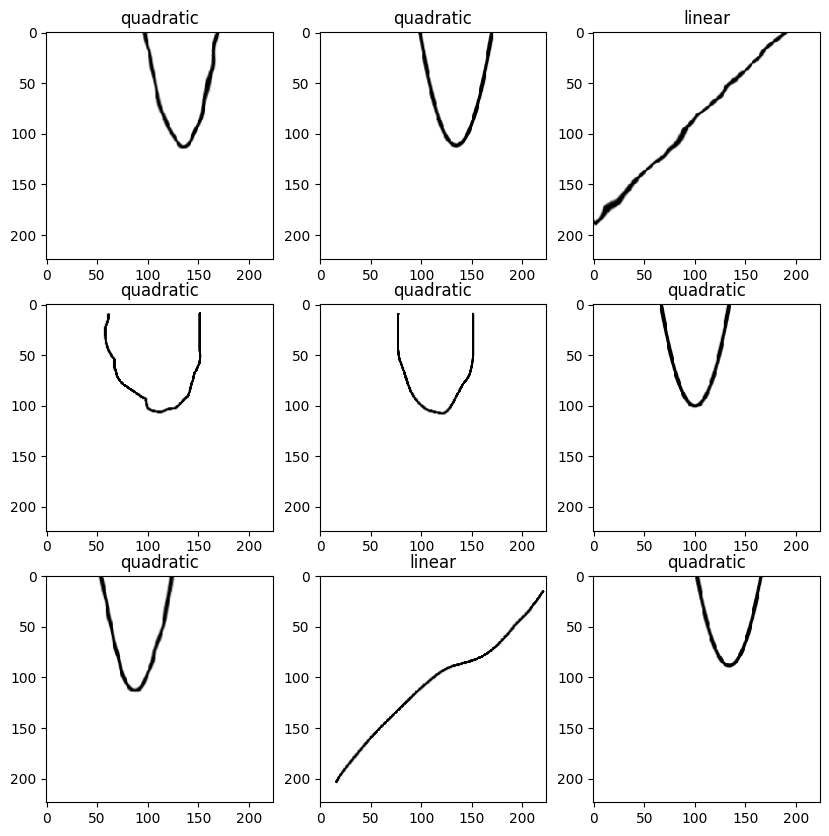

In [7]:
plt.figure(figsize=(10, 10))

for images, labels in df_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i].numpy()) # Returns the indices of the maximum values.
    plt.title(class_names[label_index])



## Dataset Optimization

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

df_train = (
    df_train_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
df_valid = (
    df_valid_
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## Model Definition

In [43]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    hub.KerasLayer(
        "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-224-feature-vector/2",
        trainable=False
        ),  
    layers.Flatten(), # Used to transition from convolutional layer to fully connected layer
    layers.Dense(6, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [44]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [45]:
history = model.fit(
    df_train,
    validation_data=df_valid,
    epochs=5
    )

Epoch 1/5
11/11 [==============================] - 2s 68ms/step - loss: 0.5498 - binary_accuracy: 0.9141 - val_loss: 0.3838 - val_binary_accuracy: 1.0000
Epoch 2/5
11/11 [==============================] - 0s 43ms/step - loss: 0.2717 - binary_accuracy: 1.0000 - val_loss: 0.2068 - val_binary_accuracy: 1.0000
Epoch 3/5
11/11 [==============================] - 0s 43ms/step - loss: 0.1336 - binary_accuracy: 1.0000 - val_loss: 0.1109 - val_binary_accuracy: 1.0000
Epoch 4/5
11/11 [==============================] - 0s 42ms/step - loss: 0.0772 - binary_accuracy: 1.0000 - val_loss: 0.0697 - val_binary_accuracy: 1.0000
Epoch 5/5
11/11 [==============================] - 0s 43ms/step - loss: 0.0508 - binary_accuracy: 1.0000 - val_loss: 0.0492 - val_binary_accuracy: 1.0000


<Axes: >

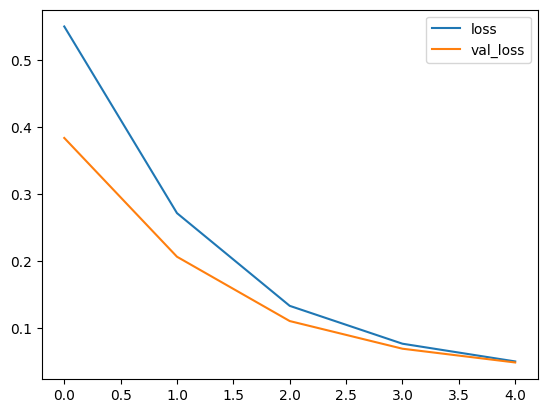

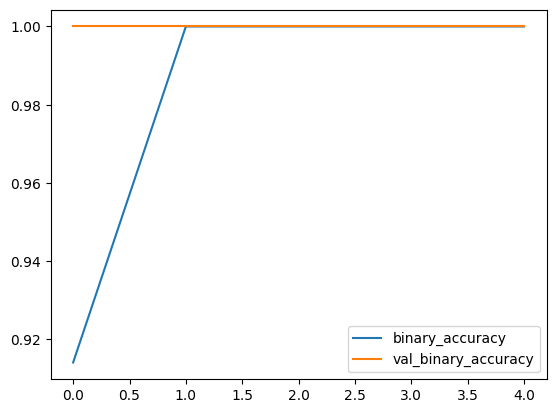

In [46]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

## Save the Model

In [47]:
model.save("model.keras")

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_4 (KerasLayer)  (None, 1280)              410208    
                                                                 
 flatten_4 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 6)                 7686      
                                                                 
 dense_9 (Dense)             (None, 2)                 14        
                                                                 
Total params: 417908 (1.59 MB)
Trainable params: 7700 (30.08 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


Test prediction of one image

In [49]:
model_loaded = load_model("model.keras", custom_objects={'KerasLayer':hub.KerasLayer})
img = Image.open("/Users/anna-alexandradanchenko/Documents/University/IdentMathFunc/Math-Functions-Identification/data/quadratic/function_2.0_0.0.png").resize((224, 224))
img = np.array(img)
img = np.expand_dims(img, axis=0)
print(img.shape)
prediction = model_loaded.predict(img)
pred_class = np.argmax(prediction)
print(class_names[pred_class])

(1, 224, 224, 3)
1/1 [==============================] - 0s 245ms/step
quadratic
